# __Exploratory Data Analysis__

In [2]:
# Python base libraries
import os

# Data science libraries
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP libraries
import nltk
from nltk.corpus import stopwords
from textblob import Word
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
import plotly.express as px

# Custom libraries
import sys
sys.path.append('..')
from functions.eda import *

### Load data

In [3]:
train_path = '../data/train.tsv'
test_path = '../data/test.tsv'
validation_path = '../data/validation.tsv'

columns = ['comment', 'label', 'id']

train = pd.read_csv(train_path, sep='\t', names=columns)
test = pd.read_csv(test_path, sep='\t', names=columns)
validation = pd.read_csv(validation_path, sep='\t', names=columns)

print(train.head())
print(test.head())
print(validation.head())

                                             comment label       id
0  My favourite food is anything I didn't have to...    27  eebbqej
1  Now if he does off himself, everyone will thin...    27  ed00q6i
2                     WHY THE FUCK IS BAYLESS ISOING     2  eezlygj
3                        To make her feel threatened    14  ed7ypvh
4                             Dirty Southern Wankers     3  ed0bdzj
                                             comment label       id
0  I’m really sorry about your situation :( Altho...    25  eecwqtt
1    It's wonderful because it's awful. At not with.     0  ed5f85d
2  Kings fan here, good luck to you guys! Will be...    13  een27c3
3  I didn't know that, thank you for teaching me ...    15  eelgwd1
4  They got bored from haunting earth for thousan...    27  eem5uti
                                             comment label       id
0  Is this in New Orleans?? I really feel like th...    27  edgurhb
1  You know the answer man, you are programmed t

- In the validation set we see that there are comments with more than one tag. This can complicate model training. Therefore, we have decided to do an explode: replicate those records as many times as necessary so that each replica has a single label. 

- But before we do that, let's check that there are no duplicates or null values in the original datasets.

### Check for duplicates

In [4]:
# Number of duplicate rows
print('Number of duplicate rows in the train dataset:', train.duplicated().sum())
print('Number of duplicate rows in the test dataset:', test.duplicated().sum())
print('Number of duplicate rows in the validation dataset:', validation.duplicated().sum())

Number of duplicate rows in the train dataset: 0
Number of duplicate rows in the test dataset: 0
Number of duplicate rows in the validation dataset: 0


### Check datatypes and missing values

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43410 entries, 0 to 43409
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  43410 non-null  object
 1   label    43410 non-null  object
 2   id       43410 non-null  object
dtypes: object(3)
memory usage: 1017.5+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5427 entries, 0 to 5426
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  5427 non-null   object
 1   label    5427 non-null   object
 2   id       5427 non-null   object
dtypes: object(3)
memory usage: 127.3+ KB


In [7]:
validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5426 entries, 0 to 5425
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  5426 non-null   object
 1   label    5426 non-null   object
 2   id       5426 non-null   object
dtypes: object(3)
memory usage: 127.3+ KB


### Explode the datasets so that there is only 1 label per record

In [8]:
# First test with the validation df, as we can check already printing the first 5 rows.

# Split the labels in a new column
validation['labels_list'] = validation['label'].str.split(',')

# Explode the dataframe based on the labels_list column
validation = validation.explode('labels_list')

# Delete the label column
validation = validation.drop(columns = ['label'])

# Rename the labels_list column to 'label'
validation = validation.rename(columns = {'labels_list' : 'label'})

# Print the first 5 rows to check
validation.head()

,comment,id,label
0,Is this in New Orleans?? I really feel like th...,edgurhb,27
1,"You know the answer man, you are programmed to...",ee84bjg,4
1,"You know the answer man, you are programmed to...",ee84bjg,27
2,I've never been this sad in my life!,edcu99z,25
3,The economy is heavily controlled and subsidiz...,edc32e2,4


In [9]:
# Train dataset
train['labels_list'] = train['label'].str.split(',')
train = train.explode('labels_list')
train = train.drop(columns = ['label'])
train = train.rename(columns = {'labels_list' : 'label'})

# Test dataset
test['labels_list'] = test['label'].str.split(',')
test = test.explode('labels_list')
test = test.drop(columns = ['label'])
test = test.rename(columns = {'labels_list' : 'label'})

In [10]:
# Let's see how much the number of rows has increased after the explode
print("Number of rows in the train dataset:", train.shape[0])
print("Number of rows in the test dataset:", test.shape[0])
print("Number of rows in the validation dataset:", validation.shape[0])

Number of rows in the train dataset: 51103
Number of rows in the test dataset: 6329
Number of rows in the validation dataset: 6380


- We can now also convert the label column to integer type, which reduces memory usage and improves computational efficiency.

In [11]:
# Cast column label to integer type
train['label'] = train['label'].astype(int)
test['label'] = test['label'].astype(int)
validation['label'] = validation['label'].astype(int)

### Analyse class imbalance


In [12]:
# Compute the frequencies and relative frequencies of the column label, for each dataset
train_freqs = check_class_imbalance(train, 'label').rename(columns = {'Freq' : 'Freq_train', 'RelFreq' : 'FreqRel_train'})
test_freqs = check_class_imbalance(test, 'label').rename(columns = {'Freq' : 'Freq_test', 'RelFreq' : 'FreqRel_test'})
validation_freqs = check_class_imbalance(validation, 'label').rename(columns = {'Freq' : 'Freq_validation', 'RelFreq' : 'FreqRel_validation'})

# Merge the dataframes on the column label, in order to print all the results together
merged_df = train_freqs.merge(test_freqs, on='label', how='outer')
merged_df = merged_df.merge(validation_freqs, on='label', how='outer')
merged_df = merged_df.sort_values(by='label')
merged_df

,label,Freq_train,FreqRel_train,Freq_test,FreqRel_test,Freq_validation,FreqRel_validation
0,0,4130,0.080817,504,0.079633,488,0.076489
1,1,2328,0.045555,264,0.041713,303,0.047492
2,2,1567,0.030664,198,0.031285,195,0.030564
3,3,2470,0.048334,320,0.050561,303,0.047492
4,4,2939,0.057511,351,0.055459,397,0.062226
5,5,1087,0.021271,135,0.021330,153,0.023981
6,6,1368,0.026769,153,0.024174,152,0.023824
7,7,2191,0.042874,284,0.044873,248,0.038871
8,8,641,0.012543,83,0.013114,77,0.012069
9,9,1269,0.024832,151,0.023858,163,0.025549


- When training a model, an unbalanced dataset can lead to a bias in favor of the most frequent class. To avoid this, techniques such as up-sampling (adding samples from minority classes), down-sampling (reducing samples from majority classes) or a combination of both can be used.

- Label 27 does not correspond to any emotion, it is the 'neutral' class. This makes sense, since there may be many comments that do not reflect any emotion. However, it is necessary to remove many of these comments to ensure correct training of the models. To do this, we proceed to downsampling by removing a determined number of random records with label 27.

In [13]:
# Filter records with label 27
train_27_all = train[train['label'] == 27]
test_27_all = test[test['label'] == 27]
validation_27_all = validation[validation['label'] == 27]

# Select a random sample of the records with the label 27
train_27_sample = train_27_all.sample(n=10000, random_state=42) 
test_27_sample = test_27_all.sample(n=1300, random_state=42) 
validation_27_sample = validation_27_all.sample(n=1300, random_state=42) 

# Remove the selected sample from the original df
train = train.drop(train_27_sample.index)
test = test.drop(test_27_sample.index)
validation = validation.drop(validation_27_sample.index)

In [14]:
# Compute the frequencies and relative frequencies of the column label, for each dataset
train_freqs = check_class_imbalance(train, 'label').rename(columns = {'Freq' : 'Freq_train', 'RelFreq' : 'FreqRel_train'})
test_freqs = check_class_imbalance(test, 'label').rename(columns = {'Freq' : 'Freq_test', 'RelFreq' : 'FreqRel_test'})
validation_freqs = check_class_imbalance(validation, 'label').rename(columns = {'Freq' : 'Freq_validation', 'RelFreq' : 'FreqRel_validation'})

# Merge the dataframes on the column label, in order to print all the results together
merged_df = train_freqs.merge(test_freqs, on='label', how='outer')
merged_df = merged_df.merge(validation_freqs, on='label', how='outer')
merged_df = merged_df.sort_values(by='label')
merged_df

,label,Freq_train,FreqRel_train,Freq_test,FreqRel_test,Freq_validation,FreqRel_validation
0,0,4062,0.101319,495,0.101144,479,0.096826
1,1,2289,0.057095,257,0.052513,295,0.059632
2,2,1522,0.037964,192,0.039232,191,0.038609
3,3,2372,0.059165,301,0.061504,287,0.058015
4,4,2802,0.069891,333,0.068043,378,0.076410
5,5,1043,0.026016,133,0.027176,145,0.029311
6,6,1301,0.032451,144,0.029424,142,0.028704
7,7,2106,0.052530,268,0.054761,234,0.047301
8,8,622,0.015515,83,0.016960,77,0.015565
9,9,1221,0.030456,144,0.029424,158,0.031939


- We have removed the very large imbalance that label 27 had with respect to the others. However, we see that label 27 and also label 0 continue to appear significantly more frequently than the others. Let's remove a little bit more.

In [15]:
#########################
# Downsampling label 27 #
#########################

# Filter records with label 27
train_27_all = train[train['label'] == 27]
test_27_all = test[test['label'] == 27]
validation_27_all = validation[validation['label'] == 27]

# Select a random sample of the records with the label 27
train_27_sample = train_27_all.sample(n=1700, random_state=42) 
test_27_sample = test_27_all.sample(n=150, random_state=42) 
validation_27_sample = validation_27_all.sample(n=90, random_state=42) 

# Remove the selected sample from the original df
train = train.drop(train_27_sample.index)
test = test.drop(test_27_sample.index)
validation = validation.drop(validation_27_sample.index)

########################
# Downsampling label 0 #
########################

# Filter records with label 0
train_0_all = train[train['label'] == 0]
test_0_all = test[test['label'] == 0]
validation_0_all = validation[validation['label'] == 0]

# Select a random sample of the records with the label 0
train_0_sample = train_0_all.sample(n=1700, random_state=42) 
test_0_sample = test_0_all.sample(n=150, random_state=42) 
validation_0_sample = validation_0_all.sample(n=90, random_state=42) 

# Remove the selected sample from the original df
train = train.drop(train_0_sample.index)
test = test.drop(test_0_sample.index)
validation = validation.drop(validation_0_sample.index)

In [16]:
# Compute the frequencies and relative frequencies of the column label, for each dataset
train_freqs = check_class_imbalance(train, 'label').rename(columns = {'Freq' : 'Freq_train', 'RelFreq' : 'FreqRel_train'})
test_freqs = check_class_imbalance(test, 'label').rename(columns = {'Freq' : 'Freq_test', 'RelFreq' : 'FreqRel_test'})
validation_freqs = check_class_imbalance(validation, 'label').rename(columns = {'Freq' : 'Freq_validation', 'RelFreq' : 'FreqRel_validation'})

# Merge the dataframes on the column label, in order to print all the results together
merged_df = train_freqs.merge(test_freqs, on='label', how='outer')
merged_df = merged_df.merge(validation_freqs, on='label', how='outer')
merged_df = merged_df.sort_values(by='label')
merged_df

,label,Freq_train,FreqRel_train,Freq_test,FreqRel_test,Freq_validation,FreqRel_validation
0,0,2351,0.065533,343,0.075784,388,0.081995
1,1,2253,0.062801,253,0.055899,293,0.061919
2,2,1510,0.042091,191,0.042201,190,0.040152
3,3,2349,0.065477,298,0.065842,287,0.060651
4,4,2662,0.074202,328,0.072470,373,0.078825
5,5,1026,0.028599,129,0.028502,142,0.030008
6,6,1281,0.035707,143,0.031595,140,0.029586
7,7,2063,0.057505,267,0.058992,234,0.049451
8,8,607,0.016920,81,0.017897,75,0.015850
9,9,1210,0.033728,144,0.031816,157,0.033178


In [17]:
# Print the new number of rows after removal
print("Number of rows in the train dataset:", train.shape[0])
print("Number of rows in the test dataset:", test.shape[0])
print("Number of rows in the validation dataset:", validation.shape[0])

Number of rows in the train dataset: 35875
Number of rows in the test dataset: 4526
Number of rows in the validation dataset: 4732


### Text preprocessing

- In NLP tasks, text preprocessing is necessary to transform the data into a format more suitable for analysis and modeling. This usually involves a number of steps, including:

    - Convert all text to lowercase to avoid treating the same word as different.

    - Expand contractions (e.g., “isn't” to “is not”) to normalize the text.

    - Eliminate stop words, common words that appear frequently but do not contribute semantic meaning to the context of the text (e.g, “the”, “of”, “in”, “by”).

    - Lemmatize words (reduce them to their root: e.g., “was” to “to be”) so that the model stays with the primary meaning.

In [18]:
# Create new datasets to apply the transformations
train_prep = train.copy()
test_prep = test.copy()
validation_prep = validation.copy()

# Load contractions csv as Pandas Dataframe
contractions = pd.read_csv('../data/contractions.csv', sep=';')

# Apply lower_and_contractions function
train_prep['comment'] = train['comment'].apply(lambda x: lower_and_contractions(x, contractions))
test_prep['comment'] = test['comment'].apply(lambda x: lower_and_contractions(x, contractions))
validation_prep['comment'] = validation['comment'].apply(lambda x: lower_and_contractions(x, contractions))

In [19]:
# Download stopwords 
nltk.download('stopwords')
stop_words = stopwords.words("english")

# Download wordnet
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# Apply stopwords_and_lemmatizer function
train_prep['comment'] = train_prep['comment'].apply(lambda x: stopwords_and_lemmatizer(x, stop_words, lemmatizer))
test_prep['comment'] = test_prep['comment'].apply(lambda x: stopwords_and_lemmatizer(x, stop_words, lemmatizer))
validation_prep['comment'] = validation_prep['comment'].apply(lambda x: stopwords_and_lemmatizer(x, stop_words, lemmatizer))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Minerva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Minerva\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [20]:
# Check the difference
pd.set_option('display.max_colwidth', None)
print('BEFORE PROCESSING\n')
print(test['comment'].head(10))
print('\nAFTER PROCESSING\n')
print(test_prep['comment'].head(10))

BEFORE PROCESSING

0                                                       I’m really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett!
2                                                                             Kings fan here, good luck to you guys! Will be an interesting game to watch! 
3                                                                                            I didn't know that, thank you for teaching me something today!
5     Thank you for asking questions and recognizing that there may be things that you don’t know or understand about police tactics. Seriously. Thank you.
6                                                                                                                                            You’re welcome
7                                                                                                                           100%! Congrats on your job too!
8                                            

### Frecuency distribution

__1. Number of occurrences of every word__

In [21]:
# Train dataset
words_count_train = get_word_counts(train_prep, "comment")
words_count_train

,word,frequency
0,name,5822
1,like,2841
2,love,2283
3,would,2226
4,get,1796
...,...,...
19175,hamburgler,1
19176,heifer,1
19177,omgggg,1
19178,stassi,1


In [22]:
# Test dataset
words_count_test = get_word_counts(test_prep, "comment")
words_count_test

,word,frequency
0,name,758
1,like,362
2,love,284
3,would,253
4,get,229
...,...,...
5999,imagery,1
6000,noed,1
6001,crease,1
6002,photoshop,1


In [23]:
# Validation dataset
words_count_validation = get_word_counts(validation_prep, "comment")
words_count_validation

,word,frequency
0,name,728
1,like,369
2,love,307
3,would,305
4,get,252
...,...,...
6234,haunt,1
6235,ethnically,1
6236,nationality,1
6237,ethnicity,1


- We can see that for all three datasets the top 4 most repeated words are preserved: name, like, love and would. This is a very good sign that the division of the data into subsets of train, test and validation is done correctly, in a uniform way.

__2. Frecuency distribution of the 50 most common words__

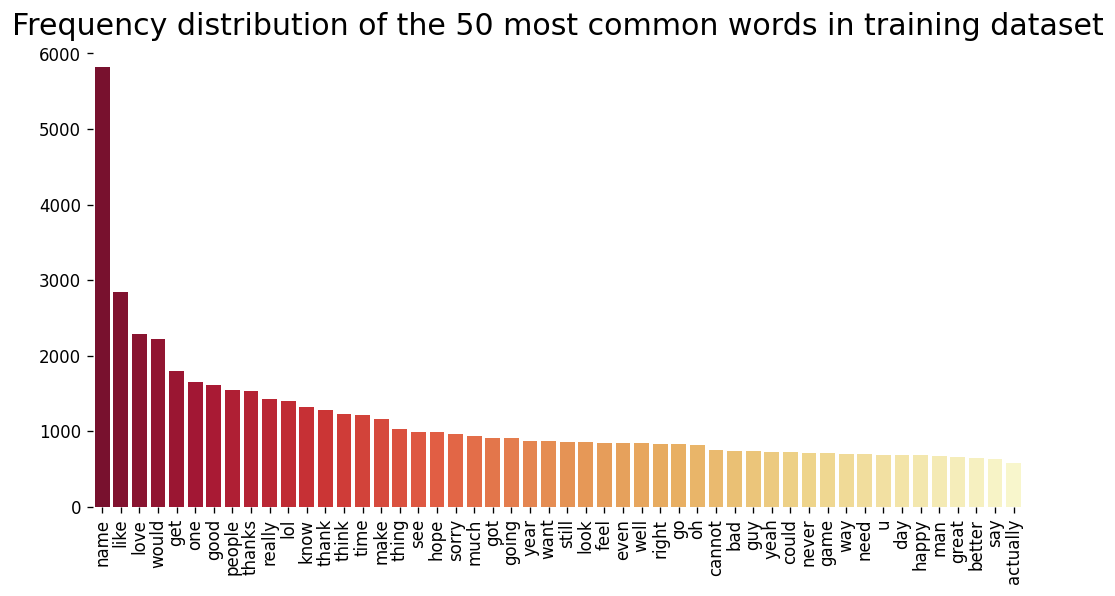

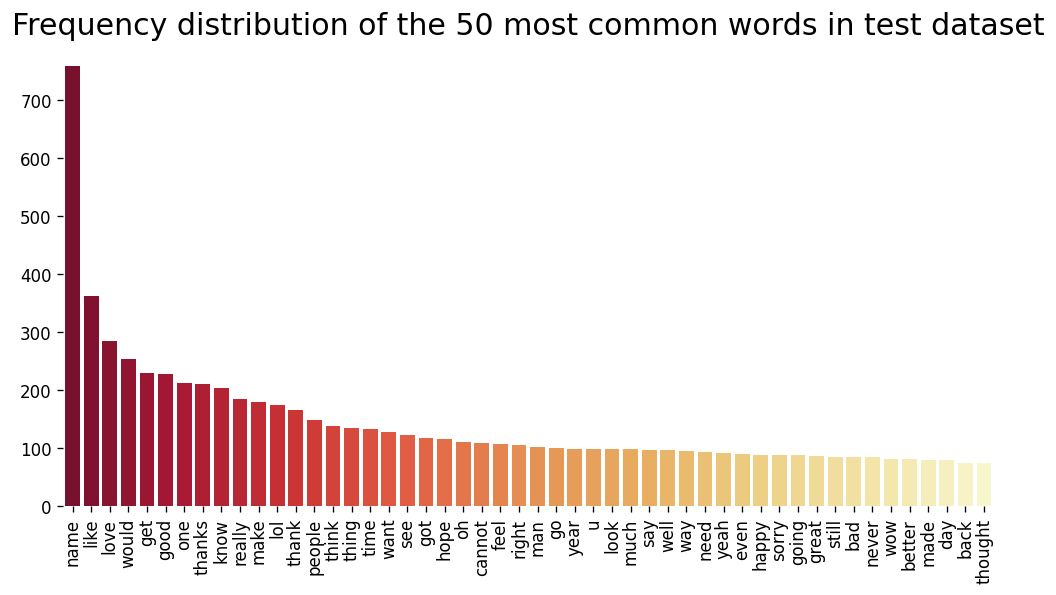

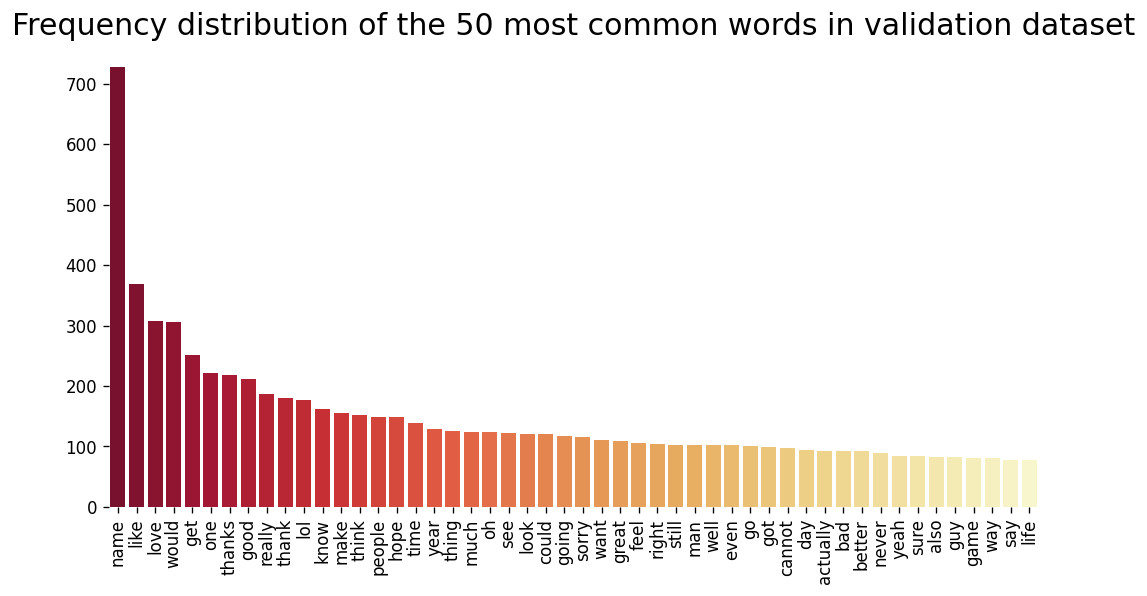

In [24]:
# Plot the frequency distribution of the 50 most common words in the dataset
plot_top_n_words_frequency(words_count_train, "word", "frequency", 50, "training")
plot_top_n_words_frequency(words_count_test, "word", "frequency", 50, "test")
plot_top_n_words_frequency(words_count_validation, "word", "frequency", 50, "validation")

- Again, we see that the frecuency distributions of the 50 most common words looks very similar for all three datasets, and most of the words that make up the top 50 are also repeated. For a better overview of which words are the most recurrent, we proceed to run a word cloud for each dataset.

__3. Word cloud__

TRAINING DATASET


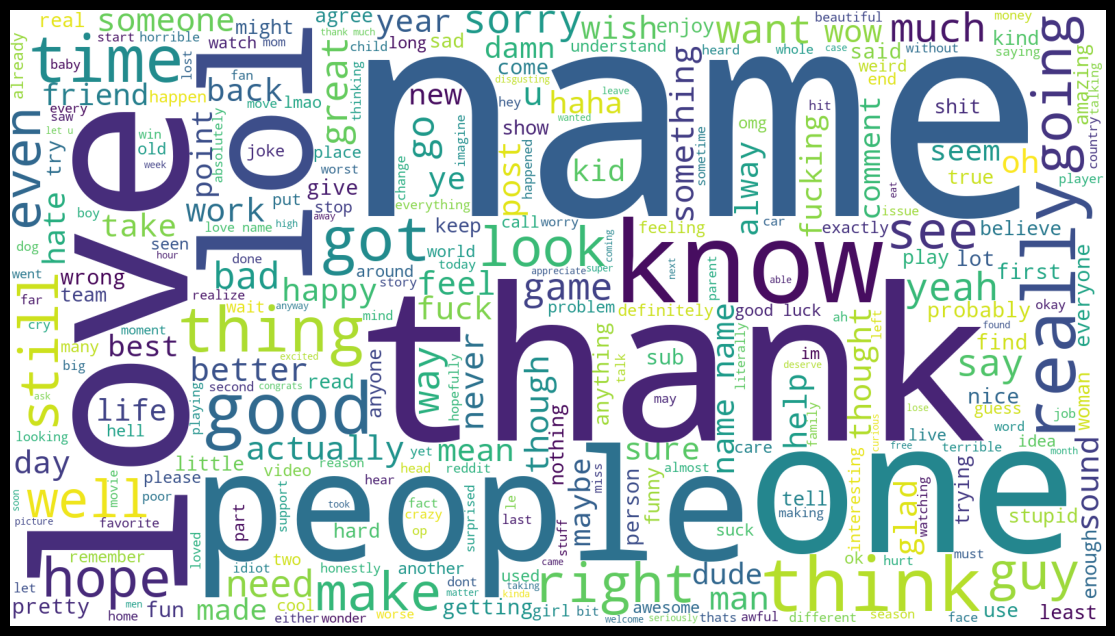

TEST DATASET


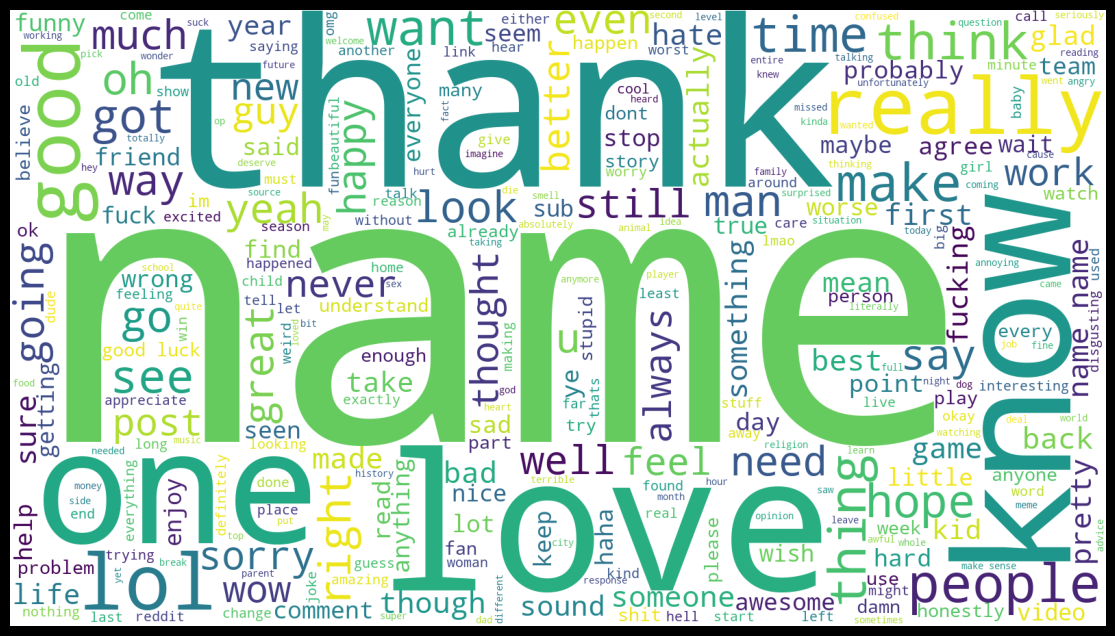

VALIDATION DATASET


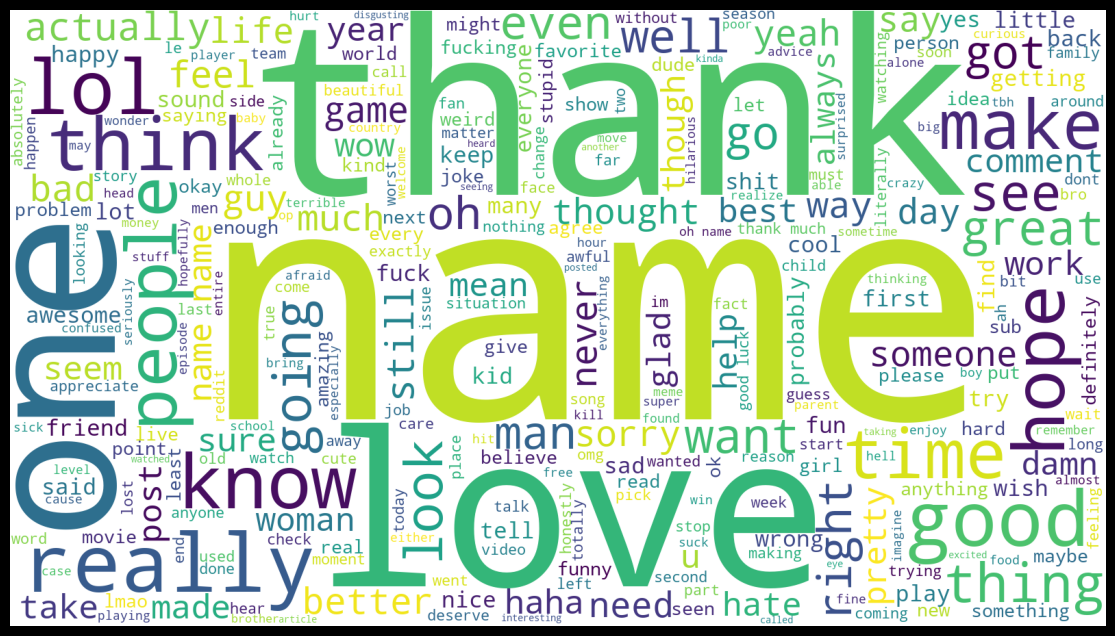

In [25]:
plot_wordcloud(train_prep, "comment", "TRAINING")
plot_wordcloud(test_prep, "comment", "TEST")
plot_wordcloud(validation_prep, "comment", "VALIDATION")

In [26]:
# Create a table with the number of different words with less than 10, 5, 4, 3 and 2 occurrences
print('TRAINING DATASET')
print(min_word_counts(words_count_train))
print('TEST DATASET')
print(min_word_counts(words_count_test))
print('VALIDATION DATASET')
print(min_word_counts(words_count_validation))

TRAINING DATASET
   frequency  number_of_words  percentage
0         10            16456   85.797706
1          5            14810   77.215850
2          4            14178   73.920751
3          3            13238   69.019812
4          2            11784   61.438999
TEST DATASET
   frequency  number_of_words  percentage
0         10             5532   92.138574
1          5             5120   85.276482
2          4             4933   82.161892
3          3             4605   76.698867
4          2             4105   68.371086
VALIDATION DATASET
   frequency  number_of_words  percentage
0         10             5753   92.210290
1          5             5310   85.109793
2          4             5117   82.016349
3          3             4793   76.823209
4          2             4266   68.376342


- We see in the vast majority of words they appear very few times. In fact, more than half of the words appear only once: 61.4% in training, 68.4% in test and validation. 

- These types of words that appear so rarely do not usually provide much information and, in contrast, can introduce noise to our models. Therefore, we have decided to make a sieve, according to the size of the dataset. In the training dataset, as it has to be considerably more large, we will not remove unfrequent words, while in the test and validation datasets we will remove words that appear only once (i.e. less than 2 times).

In [27]:
# Train dataset
word_freq = dict(zip(words_count_train["word"], words_count_train["frequency"]))
train_prep["comment"] = train_prep["comment"].apply(filter_words_by_frequency, args=(word_freq, 3))

# Test dataset
word_freq = dict(zip(words_count_test["word"], words_count_test["frequency"]))
test_prep["comment"] = test_prep["comment"].apply(filter_words_by_frequency, args=(word_freq, 2))

# Validation dataset
word_freq = dict(zip(words_count_validation["word"], words_count_validation["frequency"]))
validation_prep["comment"] = validation_prep["comment"].apply(filter_words_by_frequency, args=(word_freq, 2))

In [28]:
# Check 
words_count_train_prep = get_word_counts(train_prep, "comment")
words_count_test_prep = get_word_counts(test_prep, "comment")
words_count_validation_prep = get_word_counts(validation_prep, "comment")
print("Number of different words BEFORE REMOVAL")
print(f"  - In the TRAINING dataset: {len(words_count_train)}")
print(f"  - In the TEST dataset: {len(words_count_test)}")
print(f"  - In the VALIDATION dataset: {len(words_count_validation)}")
print("\nNumber of different words AFTER REMOVAL")
print(f"  - In the TRAINING dataset: {len(words_count_train_prep)}")
print(f"  - In the TEST dataset: {len(words_count_test_prep)}")
print(f"  - In the VALIDATION dataset: {len(words_count_validation_prep)}")

Number of different words BEFORE REMOVAL
  - In the TRAINING dataset: 19180
  - In the TEST dataset: 6004
  - In the VALIDATION dataset: 6239

Number of different words AFTER REMOVAL
  - In the TRAINING dataset: 5942
  - In the TEST dataset: 1899
  - In the VALIDATION dataset: 1973


- After the removal of rare words, some comments may be left as an empty string and should be removed. Let's check it out.

In [29]:
# Select the 'comment' column as input variable
X_train = train_prep[['comment']]
X_test = test_prep[['comment']]
X_val = validation_prep[['comment']] 

# Select the 'label' columns as output variable
y_train = train_prep[['label']]
y_test = test_prep[['label']]
y_val = validation_prep[['label']]

# Replace empty strings by NaN in the input dataframes
X_train.replace("", float('NaN'), inplace=True)
X_test.replace("", float('NaN'), inplace=True)
X_val.replace("", float('NaN'), inplace=True)

C:\Users\Minerva\AppData\Local\Temp\ipykernel_15756\208294830.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.replace("", float('NaN'), inplace=True)
C:\Users\Minerva\AppData\Local\Temp\ipykernel_15756\208294830.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.replace("", float('NaN'), inplace=True)
C:\Users\Minerva\AppData\Local\Temp\ipykernel_15756\208294830.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

In [30]:
# Check missing values
print(X_train.info())
print(X_test.info())
print(X_val.info())

<class 'pandas.core.frame.DataFrame'>
Index: 35875 entries, 2 to 43409
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  35713 non-null  object
dtypes: object(1)
memory usage: 560.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 4526 entries, 0 to 5426
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  4467 non-null   object
dtypes: object(1)
memory usage: 70.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 4732 entries, 2 to 5425
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  4678 non-null   object
dtypes: object(1)
memory usage: 73.9+ KB
None


In [31]:
# Identify the indices of null records in the input dataframes
null_indices_train = X_train[X_train.isnull().any(axis=1)].index
null_indices_test = X_test[X_test.isnull().any(axis=1)].index
null_indices_val = X_val[X_val.isnull().any(axis=1)].index

# Remove null records from the input dataframes
X_train = X_train.dropna()
X_test = X_test.dropna()
X_val = X_val.dropna()

# Use the identified indices to remove corresponding records in the output dataframes
y_train = y_train.drop(null_indices_train)
y_test = y_test.drop(null_indices_test)
y_val = y_val.drop(null_indices_val)

# Check
if len(X_train.index) == len(y_train.index) and len(X_test.index) == len(y_test.index) and len(X_val.index) == len(y_val.index):
    print("All correct.")
else:
    print("There is a pair of input-output dataframes with different number of rows.")

All correct.


### Save the final dataframes

- We are going to save the dataframes already divided into inputs (column a 'comment') and outputs (column 'label')

In [32]:
# Input dataframes
X_train.to_csv('../data/X_train.tsv', sep='\t', index=False)
X_test.to_csv('../data/X_test.tsv', sep='\t', index=False)
X_val.to_csv('../data/X_val.tsv', sep='\t', index=False)

# Output dataframes
y_train.to_csv('../data/y_train.tsv', sep='\t', index=False)
y_test.to_csv('../data/y_test.tsv', sep='\t', index=False)
y_val.to_csv('../data/y_val.tsv', sep='\t', index=False)